# Lesson 3: Part 1: Balancing and Augmenting Structured Data

## import local

In [1]:
!conda list

# packages in environment at /Users/brucecottman/anaconda3/envs/paso:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
absl-py                   0.7.0                    pypi_0    pypi
alabaster                 0.7.12                   py37_0  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.6                    py37_0  
anaconda-project          0.8.2                    py37_0  
ansimarkup                1.4.0                    pypi_0    pypi
appnope                   0.1.0                    py37_0  
appscript                 1.0.1            py37h1de35cc_1  
asn1crypto                0.24.0                   py37_0  
astor                     0.7.1                    pypi_0    pypi
astroid                   2.1.0                    py37_0  
astropy                   3.1              py37h1de35cc_0  
atomicwrites              1.2.1                    py37_0  
att

In [2]:
from __future__ import print_function
__file__ = !cd .. ;pwd
__file__ = __file__[0]
__file__

'/Users/brucecottman/Documents/PROJECTS/paso'

In [3]:
import sys
from random import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary

import warnings
warnings.filterwarnings("ignore")
import multiprocessing
OMP_NUM_THREADS=1
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import seaborn as sns
color = sns.color_palette()
sns.set(rc={'figure.figsize':(6,4)})

In [4]:
sys.path.append(__file__)
sys.path

['/Users/brucecottman/Documents/PROJECTS/paso/lessons',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python37.zip',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7/lib-dynload',
 '',
 '/Users/brucecottman/.local/lib/python3.7/site-packages',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7/site-packages',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7/site-packages/aeosa',
 '/Users/brucecottman/anaconda3/envs/paso/lib/python3.7/site-packages/IPython/extensions',
 '/Users/brucecottman/.ipython',
 '/Users/brucecottman/Documents/PROJECTS/paso']

## Part 1: Balancing and Augmenting Structured Data

Data augmentation is important because it generates (accurately) artificial data from our current existing dataset. The more data we have, the better the chosen learner will be at classification or prediction.

When data augmentation is discussed it is almost always about increasing the image data set by rotation, flipping or in some way changing the existing images to create more images. You may even come across methods for augmented unstructured data, such as words in documents. 

Structured Data Augmentation is rarely discussed in theoretical approaches and rarely appears in real-world production systems. When, it does, it is not called augmentation, but rather, class balancing or over-sampling. 

This lesson is Part 1, where I will show a simplistic approach to Structured Data Augmentation. In Part 2, the follow-on to this lesson, I will demonstrate a more complete approach that avoids a simple k-means clustering that is at the heart of over-sampling techniques such as SMOOT and ADASYN..



## A Quick Overview of paso

Along the way, we will introduce **paso** Class Balancing tools. As was shown in the previous article, **paso** supports and is compatiable with current machine learning and deep learning frameworks. **paso** is a package written in Python and some C(for speed) that was originally intended to bundle best-practices and state-of-the-art services, classes and functions for the Machine Learning and Deep Learning community. paso has grown beyond this to offer decorators, classes and methods you can use in your pipelines or custom code with or without adopting the entire **paso** package.

A pipeline is composed of steps, each step transforms the input dataset. A step will return a measurement (or dictionary of measurements), output a graph or the transformed dataset. Note: this is different, but compatible with the Scikit-Learn pipeline.
Paso currently offers the following classes: Inputer, Splitters, Cleaners, Encoders, Scalers, Balancers, Augmenters and Learners. All classes offer logging, description files and checkpointing. The last class, Learners, implements the methods: train, predict, evaluate, cross-validate and hyper-parameter optimization.

Discussion will be divided into the following major segments:
- First we load a class imbalanced dataset with a **paso** Inputer.
- Second, I will survey some of the class balancing methods offered in **paso**.
- Next, I will show that the some of the structured data augmentation offered in **paso** derive from the  class balancing methods.
- Then, I hint that these methods might be inadequate for more than just balancing augmentation of structured data.
- Finally, I finish this article with a Discussion and Summary section.


As we saw in [lesson-1](https://github.com/bcottman/paso/blob/master/lessons/lesson-1.ipynb), we need to startup **paso** services.

In [5]:
from paso.base import Paso,Log,PasoError,Param,NameToClass
from loguru import logger
session = Paso(parameters_filepath='../parameters/lesson.3.yaml').startup()

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
paso 10.10.2019 15:01:55 INFO Log started
paso 10.10.2019 15:01:55 INFO ========================================
paso 10.10.2019 15:01:55 INFO Read in parameter file: ../parameters/lesson.3.yaml


## Dataset: Yeast3

Imbalanced data sets are a special case for classification problem where the class distribution is not uniform. Typically, they are composed by two classes: The majority (negative) class and the minority (positive) class.

I have picked the yeast3 dataset as it has been well studied by biologists and machine learning scientists since the late 1990's. It can be downloaded from https://sci2s.ugr.es/keel/imbalanced.php. We load the yeast3 data set, into the dataset dataframe. The feature class will contain the class values.

In [6]:
from paso.pre.inputers import Inputers,Splitters
learner_file = '../descriptions/learners/RFC.yaml'
cv_file = '../descriptions/learners/Cross_validation_classification.yaml'
splitter_file = '../descriptions/pre/inputers/split_30_stratify.yaml'
balancer_file = '../descriptions/pre/cleaners/SMOTE.yaml'
dataset_name = 'yeast3'
inputer = Inputers(description_filepath='../descriptions/pre/inputers/'+dataset_name+'.yaml')
inputer.inputers()

['exec', 'cvs', 'xls', 'xlsm', 'text', 'image2D', 'image3D']

In [7]:
dataset = inputer.transform()
inputer.target

'Class'

In [8]:
dataset[inputer.target]= pd.Categorical(dataset[inputer.target])
dataset[inputer.target]= dataset[inputer.target].cat.codes
dataset.groupby([inputer.target]).count()

,Mcg,Gvh,Alm,Mit,Erl,Pox,Vac,Nuc
Class,,,,,,,,
0,1321,1321,1321,1321,1321,1321,1321,1321
1,163,163,163,163,163,163,163,163


In [9]:
DataFrameSummary(dataset).summary()

,Mcg,Gvh,Alm,Mit,Erl,Pox,Vac,Nuc,Class
count,1484,1484,1484,1484,1484,1484,1484,1484,1484
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.0075,0.499885,0.276199,0.109838
std,0.137299,0.123924,0.0866702,0.137098,0.048351,0.0756827,0.0577966,0.106491,0.312793
min,0.11,0.13,0.21,0,0.5,0,0,0,0
25%,0.41,0.42,0.46,0.17,0.5,0,0.48,0.22,0
50%,0.49,0.49,0.51,0.22,0.5,0,0.51,0.22,0
75%,0.58,0.57,0.55,0.32,0.5,0,0.53,0.3,0
max,1,1,1,1,1,0.83,0.73,1,1
counts,1484,1484,1484,1484,1484,1484,1484,1484,1484
uniques,81,79,53,78,2,3,48,68,2


The features for this dataset are:
- Class: predicted or dependent or target feature. The 0th class has a 8:1 ratio to the 1th class.
- Mcg: McGeoch's method for signal sequence recognition. 
- Gvh: von Heijne's method for signal sequence recognition. 
- Alm: Score of the ALOM membrane spanning region prediction program. 
- Mit: Score of discriminant analysis of the amino acid content of the N-terminal region (20 residues long) of mitochondrial and non-mitochondrial proteins. 
- Erl: Presence of "HDEL" substring (thought to act as a signal for retention in the endoplasmic reticulum lumen). Binary attribute. 
- Pox: Peroxisomal targeting signal in the C-terminus. 
- Vac: Score of discriminant analysis of the amino acid content of vacuolar and extracellular proteins. 
- Nuc: Score of discriminant analysis of nuclear localization signals of nuclear and non-nuclear protein.

These features are differ
ent types of measurements of the yeast strains. Do not worry if you do not know what they mean, as it is not important for this lesson.

### A short aside on description files


Instead of using keyword arguments cemented in code, I will use an description file. One working definition of description (from Wikipedia) is:

    "showing the relations between the concepts and categories in a subject area or domain".

- We are using description files because:
the description of an object (dataset, model, etc.) can be changed without changing code
- The parsing performance of a description file and python are about the same as both use dynamic typing. This probably would not be case for statically typed language. However, an object's metadata parsing compute is very tiny compared to the action(s) performed by the class instance in all cases encountered so far.
- A description file is language independent. It is currently formatted as a YAML file but can be also cast as a JSON or XML file.

Description files consist of hierarchy of key-value pairs. In a future lesson, I will cover description files in detail. Different description files can be viewed at: https://github.com/bcottman/paso/tree/master/descriptions.



## It is important to split first before balancing

Before training the learner it is very important to balance only the dataset we will train on. We want to know the effect of balancing data on the learner, while not corrupting our validation dataset with augmented data.

Validation is drawn from the initial train dataset in the hopes it is a sample of the past and future data that the test dataset will be drawn from. In this case our validation set is referenced as ``X_test, y_test``. The other case where train, valid, and test are sampled from the original dataset is covered by splitting the initial dataset to result in train and valid. Then split on train again to get train and test. The order does not matter so long as the second split is also on the train dataset . Here the training set will be 70%  and validation (test) set will be 30% of the original dataset.

Both ``DataFrame_to_Xy`` function and the Splitter class are in the **paso** package They are used to first separate the original dataset into ``X`` and ``y``, where ``X`` is the standard notation for a set of independent features and ``y`` is the standard notation for the dependent feature (target).

In [10]:
from paso.base import Xy_to_DataFrame, DataFrame_to_Xy
X, y = DataFrame_to_Xy(dataset, inputer.target)
splitter = Splitters(description_filepath=splitter_file)
X_train,X_test, y_train, y_test = splitter.transform(X, y,random_state=11)
train = X_train.copy()
Xy_to_DataFrame(train, y_train, inputer.target)
train.groupby([inputer.target]).count()

,Gvh,Alm,Erl,Mcg,Mit,Nuc,Pox,Vac
Class,,,,,,,,
0,924,924,924,924,924,924,924,924
1,114,114,114,114,114,114,114,114


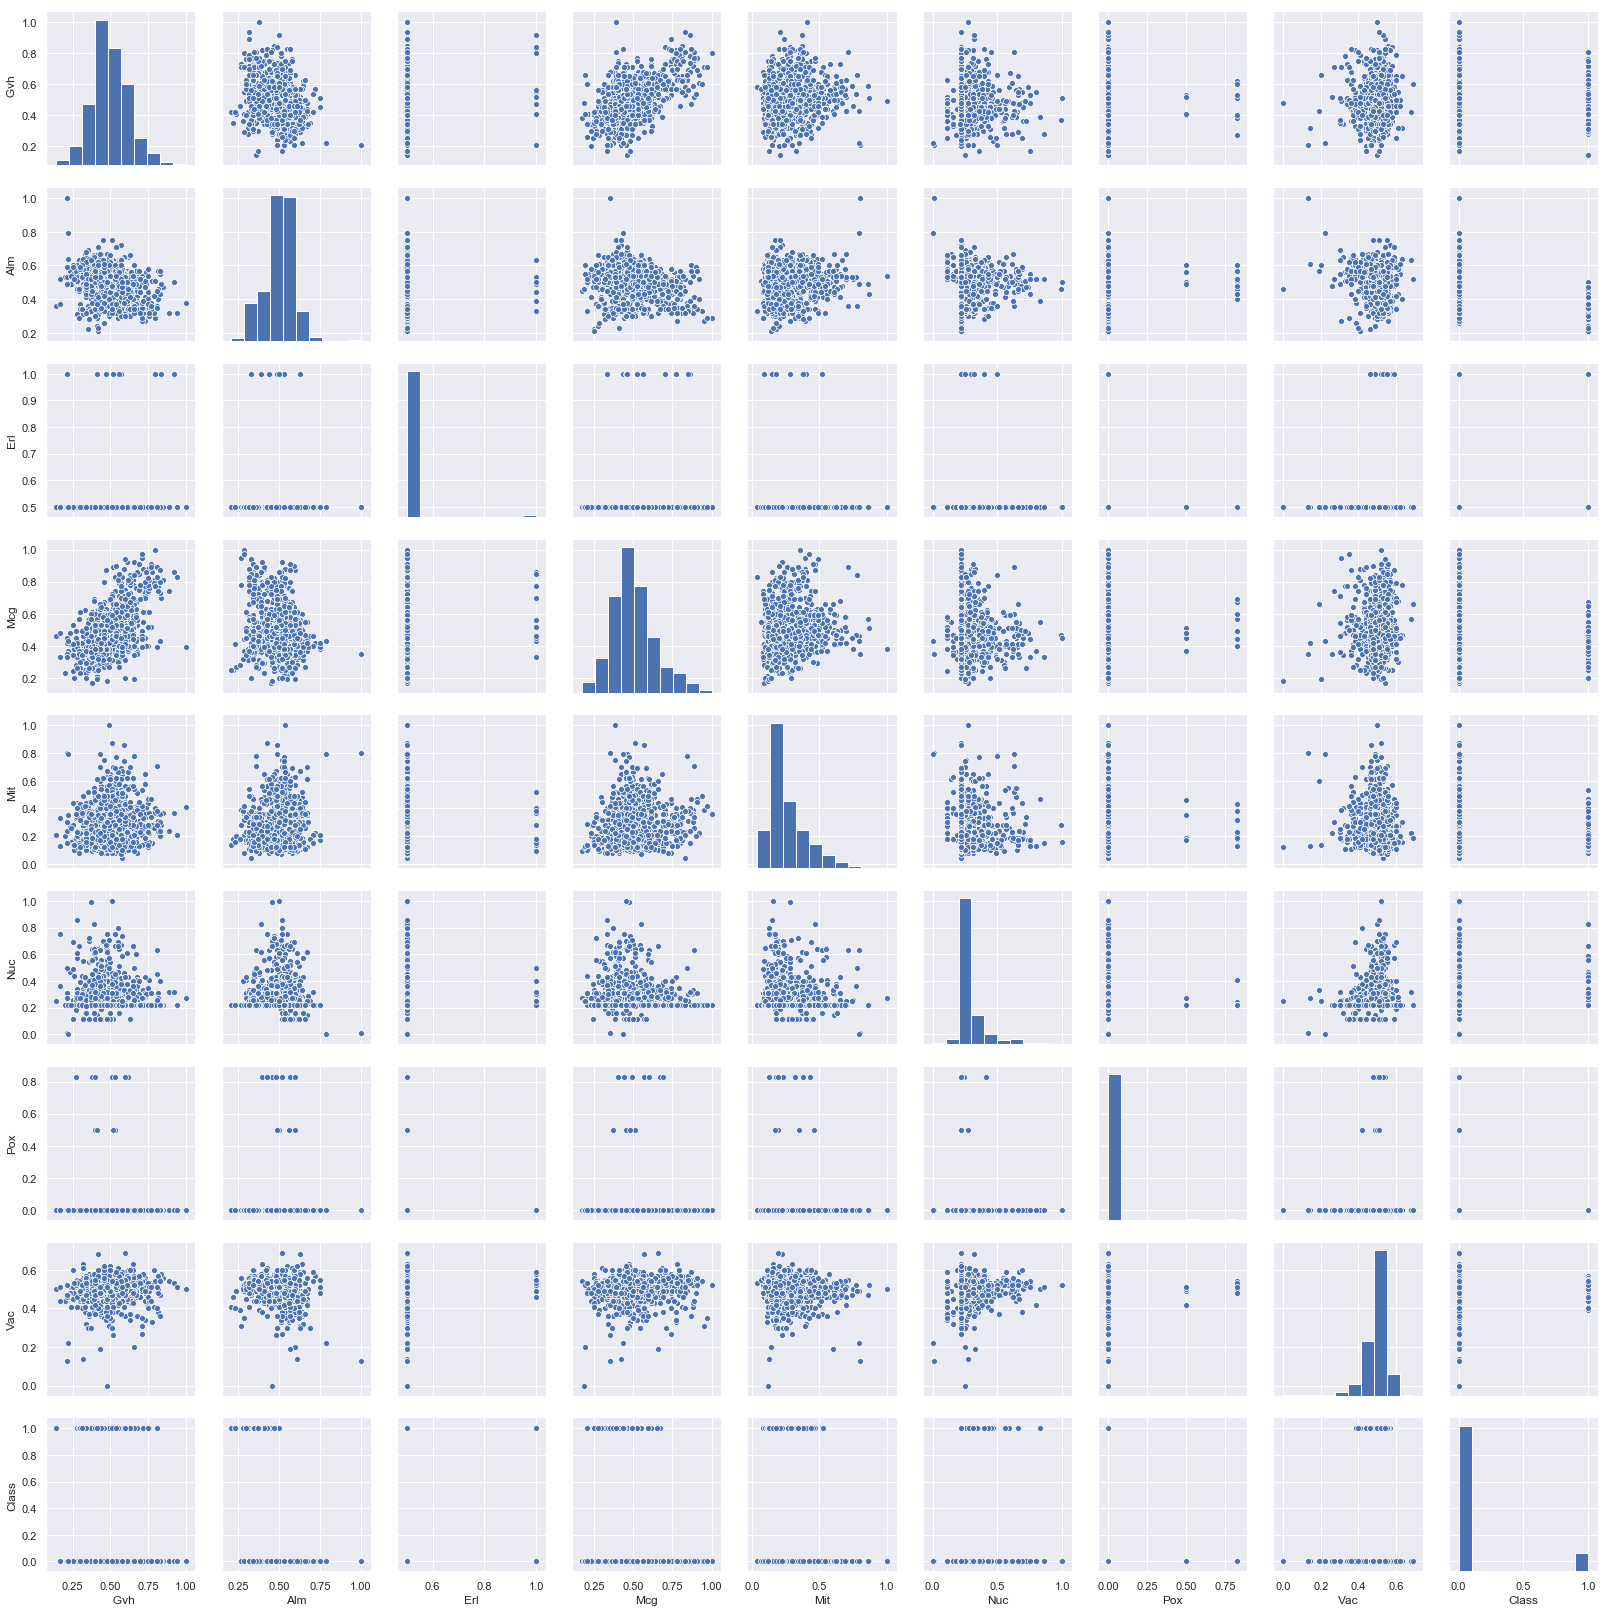

In [11]:
sns.pairplot(train)

In [12]:
DataFrameSummary(train).summary()

,Gvh,Alm,Erl,Mcg,Mit,Nuc,Pox,Vac,Class
count,1038,1038,1038,1038,1038,1038,1038,1038,1038
mean,0.498372,0.50157,0.504817,0.500645,0.264605,0.278603,0.0083237,0.49841,0.109827
std,0.121264,0.0896492,0.0488628,0.137419,0.140944,0.111716,0.0788006,0.0598107,0.312824
min,0.14,0.21,0.5,0.17,0.04,0,0,0,0
25%,0.42,0.46,0.5,0.41,0.17,0.22,0,0.48,0
50%,0.49,0.51,0.5,0.485,0.22,0.22,0,0.51,0
75%,0.57,0.56,0.5,0.5775,0.33,0.3075,0,0.53,0
max,1,1,1,1,1,1,0.83,0.69,1
counts,1038,1038,1038,1038,1038,1038,1038,1038,1038
uniques,72,53,2,79,72,66,3,44,2


Note: ``DataFrameSummary(train).summary()`` has compute time complexity of order $O(n^2)$, where $n$ is the number of elements in the underlying `` numpy`` array. You easily get this number with:

    dataset.shape[0]*dataset.shape[1]
    
A good rule of thumb is do not use ``DataFrameSummary(dataset).summary()`` where $n > 1,000,000$. You can determine how long the wait time by using smaller samples of your dataset.

## Using the RandomForest learner

Before we balance the class, let us run ``RandomForest`` learner with generic classification hyper-parameters (shown above in the description file for ``RandomForest``) on the yeast3 dataset.

In [13]:
from paso.learners.learners import Learners
learner = Learners(description_filepath=learner_file)
learner.train(X_train,y_train)
learner.cross_validate(X_train,y_train,description_filepath=cv_file)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


{'mean': {'fit_time': 0.36731834411621095,
  'score_time': 0.6522441864013672,
  'test_AOC': 0.8708297724602072,
  'test_accuracy': 0.9605302464525766,
  'test_f1_score': 0.9605302464525766,
  'test_precision': 0.9605302464525766,
  'test_recall': 0.9605302464525766,
  'test_logloss': -0.21254767821761916},
 'median': {'fit_time': 0.36589598655700684,
  'score_time': 0.6482062339782715,
  'test_AOC': 0.8397179788484136,
  'test_accuracy': 0.9519230769230769,
  'test_f1_score': 0.9519230769230769,
  'test_precision': 0.9519230769230769,
  'test_recall': 0.9519230769230769,
  'test_logloss': -0.13079809470212717},
 'std': {'fit_time': 0.00693504417091703,
  'score_time': 0.005403123850675992,
  'test_AOC': 0.0497924186197829,
  'test_accuracy': 0.01466010453063513,
  'test_f1_score': 0.01466010453063513,
  'test_precision': 0.01466010453063513,
  'test_recall': 0.01466010453063513,
  'test_logloss': 0.13933150204509637},
 'var': {'fit_time': 4.8094837652570276e-05,
  'score_time': 2.9193

In [14]:
X_train.shape

(1038, 8)

In [15]:
learner.evaluate(X_test, y_test)

{'confusion_matrix': array([[391,   6],
        [ 21,  28]]),
 'brier_loss': 0.0,
 'logloss': 0.2196107116024392,
 'accuracy': 0.9394618834080718,
 'precision': 0.886279268989149,
 'recall': 0.7781576106513134,
 'f1': 0.8206621293579757,
 'AOC': 0.7781576106513134}

This is a fairly good fit with an f1 of 0.8207.What happens when we balance class 1 with class 0 by oversampling?

### A short aside on cross-validation

In a future lesson, I will cover in detail how to use paso's cross-validation for learners that train and predict. In the meantime, you can find a good overview of cross-validation in:

[overview of cross-validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and a [detailed discussion of cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics).

In this article, I use cross_validate.This is hopefully a good choice for the structured datasets we will be using.


## paso Class for Handling Imbalanced Classes

From: https://medium.com/r/?url=https%3A%2F%2Fwww.jeremyjordan.me%2Fimbalanced-data%2F

    "Imbalanced data typically refers to a classification problem where the number of observations per class is not equally distributed; often you'll have a large amount of data/observations for one class (referred to as the majority class), and much fewer observations for one or more other classes (referred to as the minority classes).
    
From: https://medium.com/james-blogs/handling-imbalanced-data-in-classification-problems-7de598c1059f

    "Imbalanced data is not always a bad thing, and in real data sets, there is always some degree of imbalance. That said, there should not be any big impact on your model performance if the level of imbalance is relatively low.
    
    sampling techniques perform differently under different levels of imbalance. "
 
 
There are currently four different types of approaches to class balance:

1. weight assignment: These various methods put higher weight on minority classes and lower weight on majority classes. No real information is added to the dataset. Rather, this is really regulation by different classes. We have encountered no cases has this been better than the others, except when extreme undersampling or oversampling is accomplished.

1. outlier elimination: After cluster analysis, eliminate data points that are farthest from the centroid and outside the cluster. This should be accomplished under human supervision (i.e. manually). For example, a salary of $2,000,000/year is probably a real datapoint of the underlying distubution. Whereas, a spider's length of 50 meters is probably wrong. Some would argue the entire row should not be eliminated, but rather, the spurious value should be replaced with something more sensical, like the median or the mean. In any case, elimination results in lower information content.

1. undersampling: The majority class(es) members are decreased through different strategies of sampling. This is usually one of the worst approaches as the amount of data in the dataset is decreased. Again, information loss in which most models fit worse with a decrease in data. You also must be careful of underfitting, which is seen when the training dataset (with the undersample) never has a better loss metric than the validation or test dataset.

1. oversampling: The minority class(es) members are increased through different strategies of synthetic data generation. SMOTE (Synthetic Minority Oversampling Technique) and ADASYN( Adaptive Synthetic) are the most well known in the oversampling category. This is usually one of the best approaches as the amount of samples is increased. All models fit better with an increase in data. However, you should be careful of overfitting, which is seen when the training dataset (with the oversample) has a better loss metric than the validation or test dataset.

Warning: Only SMOTEC can balance datasets with categorical features. 
All others will accept a  dataset only with continuous features.

The given oversampling techniques are:

 -RandomeOverSample
- SMOTE
- ADASYN
- BorderLineSMOTE
- SVSMOTE
- SMOTENC

ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier while the basic implementation of SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule. Therefore, the decision function found during training will be different among the algorithms. However, because of distance from centroid metric, the class clusters need to be circular in shape for either method to work well.

The given undersampling techniques are:
- RandomUnderSample
- ClusterCentroids
- various versions of SMOTE
- ADASYN

The outlier elimination (results in undersampling) techniques are:

- NearMiss
- EditedNearestNeighbour
- CondensedNearestNeighbour

You can read in detail about these class balance techniques as well as examples in the extensive [imbalance-sklearn documentation](https://medium.com/r/?url=https%3A%2F%2Fimbalanced-learn.readthedocs.io%2Fen%2Fstable%2Fuser_guide.html).

All available class balance strategies are shown with:

In [16]:
from paso.pre.cleaners import Balancers
class_balancer = Balancers(description_filepath=balancer_file)

I am going to oversample the minority classes by using ``SMOOT``. I recommend [Handling imbalanced datasets in machine learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28) for more detail on how to balance class imbalanced datasets.

In [17]:
balancer = Balancers(description_filepath=balancer_file)
X_train,y_train = balancer.transform(X_train,y_train)

paso 10.10.2019 15:02:13 INFO Balancer


In [18]:
train = X_train.copy()
Xy_to_DataFrame(train, y_train, inputer.target)
train.groupby([inputer.target]).count()

,Gvh,Alm,Erl,Mcg,Mit,Nuc,Pox,Vac
Class,,,,,,,,
0,924,924,924,924,924,924,924,924
1,924,924,924,924,924,924,924,924


In [19]:
learner = Learners(description_filepath=learner_file,target=inputer.target)
learner.train(X_train,y_train)

In [20]:
learner.cross_validate(X_train,y_train,description_filepath=cv_file) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


{'mean': {'fit_time': 0.47127442359924315,
  'score_time': 0.6575253486633301,
  'test_AOC': 0.9740188014101058,
  'test_accuracy': 0.9740188014101058,
  'test_f1_score': 0.9740188014101058,
  'test_precision': 0.9740188014101058,
  'test_recall': 0.9740188014101058,
  'test_logloss': -0.08630526290291975},
 'median': {'fit_time': 0.47306203842163086,
  'score_time': 0.6572551727294922,
  'test_AOC': 0.9783783783783786,
  'test_accuracy': 0.9783783783783784,
  'test_f1_score': 0.9783783783783784,
  'test_precision': 0.9783783783783784,
  'test_recall': 0.9783783783783784,
  'test_logloss': -0.08122431646486361},
 'std': {'fit_time': 0.0032066583426906986,
  'score_time': 0.001814573124435849,
  'test_AOC': 0.011935818510398351,
  'test_accuracy': 0.011935818510398377,
  'test_f1_score': 0.011935818510398377,
  'test_precision': 0.011935818510398377,
  'test_recall': 0.011935818510398377,
  'test_logloss': 0.022411328000847545},
 'var': {'fit_time': 1.0282657726747856e-05,
  'score_time

In [21]:
learner.evaluate(X_test, y_test)

{'confusion_matrix': array([[388,   9],
        [ 16,  33]]),
 'brier_loss': 0.0,
 'logloss': 0.1360347259659083,
 'accuracy': 0.9439461883408071,
 'precision': 0.873055162659123,
 'recall': 0.8253996812830926,
 'f1': 0.8470318695037796,
 'AOC': 0.8253996812830926}

Notice with class balancing the False-Positive for the former minority, class 1 has decreased from ``21`` to ``16`` (as shown in the confusion-matrix. Whereas the former majority class has increased False-Positive from ``6`` to ``9``. More importantly, ``f1``  has increased to ``0.8470`` and ``logloss`` has decreased to ``0.1360`` .It appears ``SMOTE`` class balancing has worked for the ``yeast3`` dataset. 

## Augment the ``yeast3``dataset.

Now we can augment (increase by 100\% the amount data) with  synthetic data generated by a claas imbalance scheme,  using ``SMOOT``.  The result is similar to image augmention in that we accomplished structured data augmentation by increasing the row count ``yeast3``dataset with synthetic data.

In [22]:
_, _, occurCount = np.unique(
    y_train, return_index=True, return_counts=True
)
occurCount

array([924, 924])

In [23]:
from paso.pre.cleaners import Augmenters
augmenter = Augmenters(description_filepath=balancer_file)
ratio = 1.0
X_augment,y_augment = augmenter.transform(X_train,y_train,ratio=ratio, verbose=True)
_, _, occurCount = np.unique(
    y_augment, return_index=True, return_counts=True
)
occurCount

paso 10.10.2019 15:02:16 INFO Augmenter ratio: 1.0


array([1848, 1848])

Notice the ``mean``, ``std`` and other statistics have slightly changed. Also, the count has inreased by 10% or augmented a structured dataset by 10%. Why do expect slight and not large change in the dataset statistics?

In [24]:
learner = Learners(description_filepath=learner_file,target=inputer.target)
learner.train(X_augment,y_augment )
learner.cross_validate(X_augment,y_augment ,description_filepath=cv_file) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


{'mean': {'fit_time': 0.2613855838775635,
  'score_time': 0.6523854255676269,
  'test_AOC': 0.9821504431260528,
  'test_accuracy': 0.9821504431260528,
  'test_f1_score': 0.9821504431260528,
  'test_precision': 0.9821504431260528,
  'test_recall': 0.9821504431260528,
  'test_logloss': -0.057054722406789625},
 'median': {'fit_time': 0.2619750499725342,
  'score_time': 0.6528260707855225,
  'test_AOC': 0.9864498644986449,
  'test_accuracy': 0.986449864498645,
  'test_f1_score': 0.986449864498645,
  'test_precision': 0.986449864498645,
  'test_recall': 0.986449864498645,
  'test_logloss': -0.057078823577252295},
 'std': {'fit_time': 0.003518415151288541,
  'score_time': 0.003771100613878443,
  'test_AOC': 0.007795623379183452,
  'test_accuracy': 0.007795623379183427,
  'test_f1_score': 0.007795623379183427,
  'test_precision': 0.007795623379183427,
  'test_recall': 0.007795623379183427,
  'test_logloss': 0.012638983164450729},
 'var': {'fit_time': 1.2379245176816767e-05,
  'score_time': 1.

In [25]:
learner.evaluate(X_test, y_test)

{'confusion_matrix': array([[389,   8],
        [ 16,  33]]),
 'brier_loss': 0.0,
 'logloss': 0.20491568588118833,
 'accuracy': 0.9461883408071748,
 'precision': 0.8826859379704908,
 'recall': 0.8266591271269212,
 'f1': 0.8517040731504573,
 'AOC': 0.8266591271269214}

Hmmm, 100% augmentation seemed to degrade ``logloss``  quite a lot, but accuracy and the other metics did not change much.

In [26]:
learner.wrong_predicted_class

,Gvh,Alm,Erl,Mcg,Mit,Nuc,Pox,Vac
265,0.35,0.42,0.5,0.48,0.21,0.22,0.0,0.57
1075,0.36,0.32,0.5,0.40,0.16,0.27,0.0,0.51
1421,0.31,0.43,0.5,0.49,0.24,0.22,0.0,0.54
1142,0.63,0.45,0.5,0.50,0.13,0.32,0.0,0.45
225,0.60,0.43,0.5,0.58,0.12,0.22,0.0,0.55
1467,0.62,0.26,0.5,0.65,0.33,0.22,0.0,0.55
1153,0.68,0.30,0.5,0.60,0.27,0.22,0.0,0.55
575,0.49,0.45,0.5,0.48,0.23,0.22,0.0,0.51
1460,0.41,0.46,0.5,0.47,0.18,0.22,0.0,0.53
894,0.37,0.32,0.5,0.23,0.13,0.22,0.0,0.53


It appears that the same row is mis-classified

### Augment Grind

In [27]:
_, _, occurCount = np.unique(
    y_augment, return_index=True, return_counts=True
)
occurCount

array([1848, 1848])

In [28]:
def grind_augment(n_grind,X_augment,y_augment,X_test, y_test):
    size = []
    score = []
    for n in tqdm(range(n_grind)):
        X_augment, y_augment = augmenter.transform(X_augment,y_augment,ratio=ratio, verbose=True)
        learner = Learners(description_filepath=learner_file)
        learner.train(X_augment,y_augment )
        learner.cross_validate(X_augment,y_augment ,description_filepath=cv_file) 
        score.append(learner.evaluate(X_test, y_test))
        size.append(X_augment.shape[0])
    return score,size

Next, I will further augment the dataset using ``SMOOTE`` 3 more times, doubling the dataset row count each time.

In [29]:
N= 3
sc,sz = grind_augment(N,X_train,y_train,X_test, y_test)

  0%|          | 0/3 [00:00<?, ?it/s]

paso 10.10.2019 15:02:19 INFO Augmenter ratio: 1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
 33%|███▎      | 1/3 [00:02<00:05,  2.57s/it]

paso 10.10.2019 15:02:22 INFO Augmenter ratio: 1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
 67%|██████▋   | 2/3 [00:05<00:02,  2.61s/it]

paso 10.10.2019 15:02:25 INFO Augmenter ratio: 1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
100%|██████████| 3/3 [00:08<00:00,  2.75s/it]


In [30]:
sc,sz 

([{'confusion_matrix': array([[389,   8],
          [ 17,  32]]),
   'brier_loss': 0.0,
   'logloss': 0.13578963898387286,
   'accuracy': 0.9439461883408071,
   'precision': 0.879064039408867,
   'recall': 0.8164550454942683,
   'f1': 0.8439839366420865,
   'AOC': 0.8164550454942682},
  {'confusion_matrix': array([[390,   7],
          [ 18,  31]]),
   'brier_loss': 0.0,
   'logloss': 0.12862226669036203,
   'accuracy': 0.9439461883408071,
   'precision': 0.8858359133126935,
   'recall': 0.807510409705444,
   'f1': 0.8407938887699008,
   'AOC': 0.8075104097054439},
  {'confusion_matrix': array([[389,   8],
          [ 18,  31]]),
   'brier_loss': 0.0,
   'logloss': 0.12784818163554648,
   'accuracy': 0.9417040358744395,
   'precision': 0.8753228753228752,
   'recall': 0.8062509638616152,
   'f1': 0.8361035730438716,
   'AOC': 0.8062509638616152}],
 [3696, 7392, 14784])

In [31]:
aa = []
for i in range(N):
    aa.append(sc[i]['f1']) 
aa

[0.8439839366420865, 0.8407938887699008, 0.8361035730438716]

In [32]:
cc = []
for i in range(N):
    cc.append(sc[i]['logloss']) 

In [33]:
df = pd.DataFrame()
df['rows'] = sz
df['logloss'] = cc
df['f1'] = aa
df

,rows,logloss,f1
0,3696,0.135790,0.843984
1,7392,0.128622,0.840794
2,14784,0.127848,0.836104


Graphing the logloss versus the row count shows:

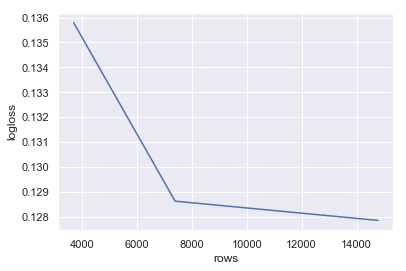

In [34]:
ax = sns.lineplot(x="rows", y="logloss", data=df)


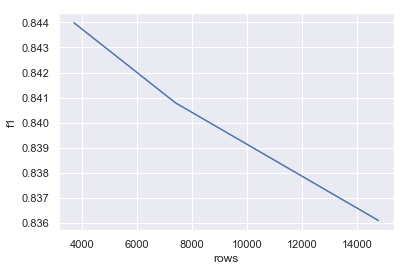

In [35]:
import seaborn
#grid = 
ax = sns.lineplot(x="rows", y="f1", data=df)

Oversampling the data using ``SMOTE's`` cluster sampling seemed to was ambiguous at best. Both ``logloss`` and ``f1``
 are decreasing!  This indicates that the clusters of ``yeast3`` are not the circular shape required by ``SMOTE``

[A good discussion of how ``SMOTE`` and ``ADASYN`` are defined and implemented.](https://medium.com/coinmonks/smote-and-adasyn-handling-imbalanced-data-set-34f5223e167)

## Conclusions and Summary

From the ``logloss`` it appears that ``SMOOT`` is doubling the error each time it doubles the size of ``yeast3`` by generating 100% of the dataset. However, I can not state conclusively that ``SMOOT`` does not generate good pseudo-data. For that I need to optimize the hyper-parameters of the learner for each augmentation, look at the shape of the data with ``PCA`` and cluster-analysis, try different learners and try different data augmenters besides ``SMOOT``.I will do this in the Part 2 of this subject.

We have introduced **paso's** data input class, ``Inputer``, and the ``Spitter`` class to split data into train, valid and test datasets. I also lightly brushed over description files that capture the description of the actions we want one of our classes to take. I stated, through casual argument, that description files are better than coded keyword arguments. Certainly, we gain some language independence from description files. Finally, I made a light foray into the use of ``learners`` and cross-validation of those ``learners``.

I have focused on the major topics of this lesson, ``Balancers`` and ``Augmenters``. We saw how to augment structured data. Balancing improved the predictive power of the learner, but in this very limited study we failed to show further data augmentation increased predictive power using SMOTE.

In future articles, I will cover **paso** in more depth with:

- Part 2 of augmenting structured data. I will use the automatic hyper-parameter tuning of **paso**, different machine learning trainers, and introduce other augmentation methods.
- Overview of **paso's** Exploratory Data Analysis (EDA) methods.
- Overview of **paso's** various data cleaners.
- Overview of **paso's** scalers and handling data outliers.
- Overview of **paso's** data encoders.
- Using paso on GPUs.

and more…

If you have a service or feature or see a bug, then leave the **paso** project a note.

Thanks for reading, I hope this gives you a better understanding of the basics of **paso** and its usage for your machine learning task.

If you enjoyed reading this, you may also enjoy some of other References and Further Resources that have been sprinkled throughout this lesson.